In [99]:
# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import random
import nltk
import warnings

In [100]:
# Sklearn & NLP
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
from wordcloud import WordCloud, STOPWORDS
from scipy.sparse import hstack

In [101]:
# Settings
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
random.seed(42)
np.random.seed(42)
%matplotlib inline

# NLTK resources
nltk.download('vader_lexicon', quiet=True)

True

In [102]:
# Load dataset
df = pd.read_csv('climate_nasa.csv')

# Basic preview
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())
display(df.info())

Shape: (522, 5)
Columns: ['date', 'likesCount', 'profileName', 'commentsCount', 'text']


,date,likesCount,profileName,commentsCount,text
0,2022-09-07T17:12:32.000Z,2,4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...,NaN,Neat comparison I have not heard it before.\n ...
1,2022-09-08T14:51:13.000Z,0,518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...,NaN,An excellent way to visualise the invisible! T...
2,2022-09-07T17:19:41.000Z,1,d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...,3.0,Does the CO2/ghg in the troposphere affect the...
3,2022-09-08T00:51:30.000Z,4,37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...,NaN,excellent post! I defo feel the difference - o...
4,2022-09-07T19:06:20.000Z,16,e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb...,26.0,"Yes, and carbon dioxide does not harm the Eart..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           522 non-null    object 
 1   likesCount     522 non-null    int64  
 2   profileName    522 non-null    object 
 3   commentsCount  244 non-null    float64
 4   text           504 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 20.5+ KB


None

In [103]:
# Drop rows where text is missing 
df = df.dropna(subset=['text'])

# Fill missing commentsCount with 0 
df['commentsCount'] = df['commentsCount'].fillna(0)

# Confirm
df.isnull().sum()

date             0
likesCount       0
profileName      0
commentsCount    0
text             0
dtype: int64

,likesCount,commentsCount
count,504.000000,504.000000
mean,4.869048,4.190476
std,12.239115,9.571715
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,4.000000,4.250000
max,126.000000,93.000000


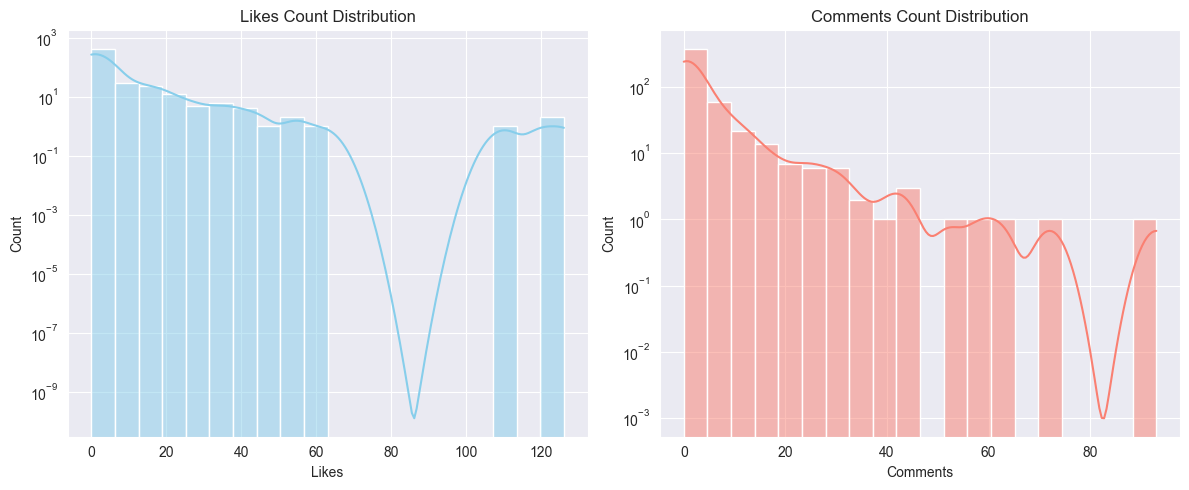

In [104]:
# Stats overview
display(df.describe())

# Visualize likes and comments count
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['likesCount'], kde=True, ax=axes[0], bins=20, color='skyblue')
axes[0].set_title("Likes Count Distribution")
axes[0].set_xlabel("Likes")
axes[0].set_yscale('log')

sns.histplot(df['commentsCount'], kde=True, ax=axes[1], bins=20, color='salmon')
axes[1].set_title("Comments Count Distribution")
axes[1].set_xlabel("Comments")
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

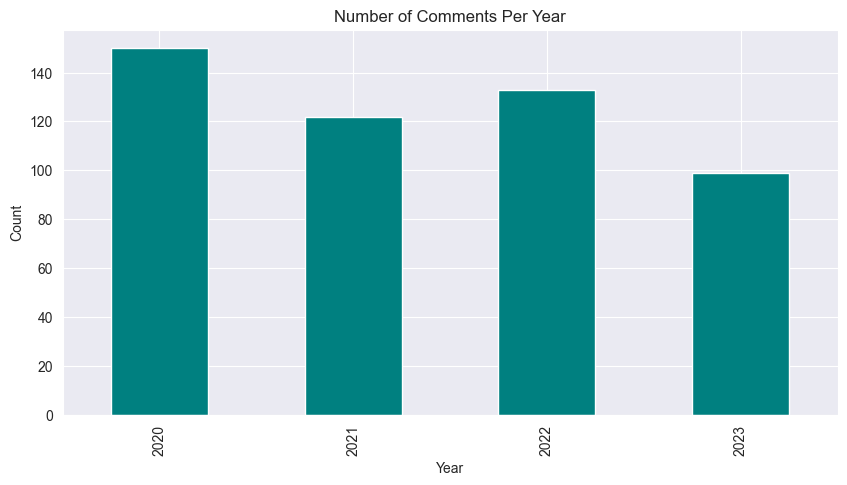

In [105]:
# Parse date and extract features
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.dropna(subset=['date'], inplace=True)

df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month
df['DayOfWeek'] = df['date'].dt.day_name()

# Yearly comment volume
plt.figure(figsize=(10, 5))
df.groupby('Year').size().plot(kind='bar', color='teal')
plt.title("Number of Comments Per Year")
plt.ylabel("Count")
plt.xlabel("Year")
plt.grid(True)
plt.show()

In [106]:
print(df.columns)

Index(['date', 'likesCount', 'profileName', 'commentsCount', 'text', 'Year',
       'Month', 'DayOfWeek'],
      dtype='object')


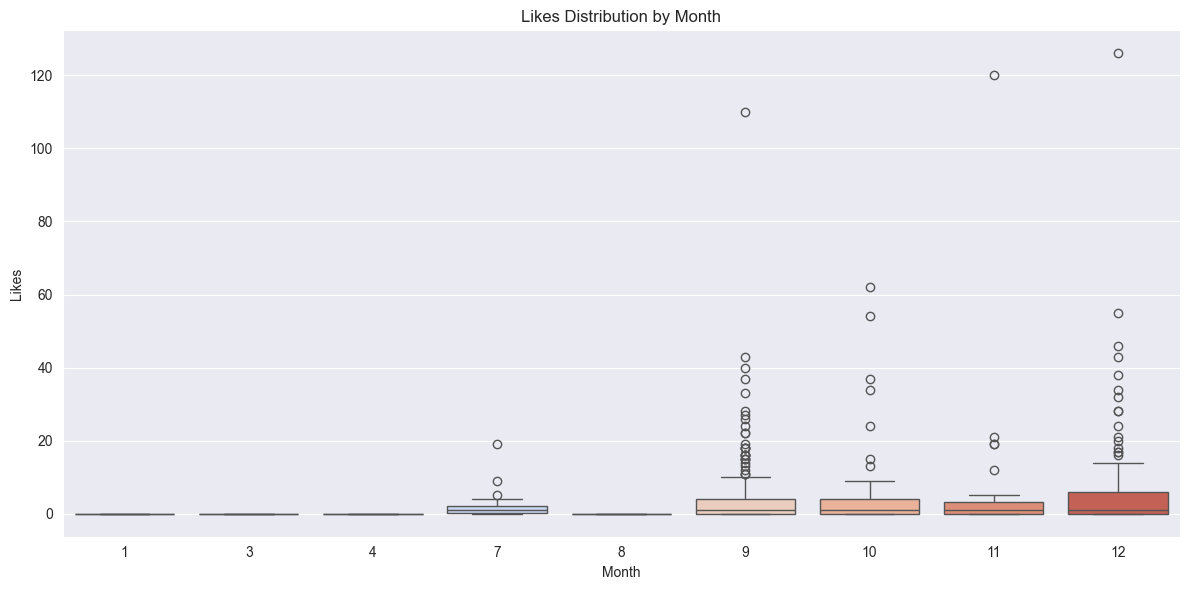

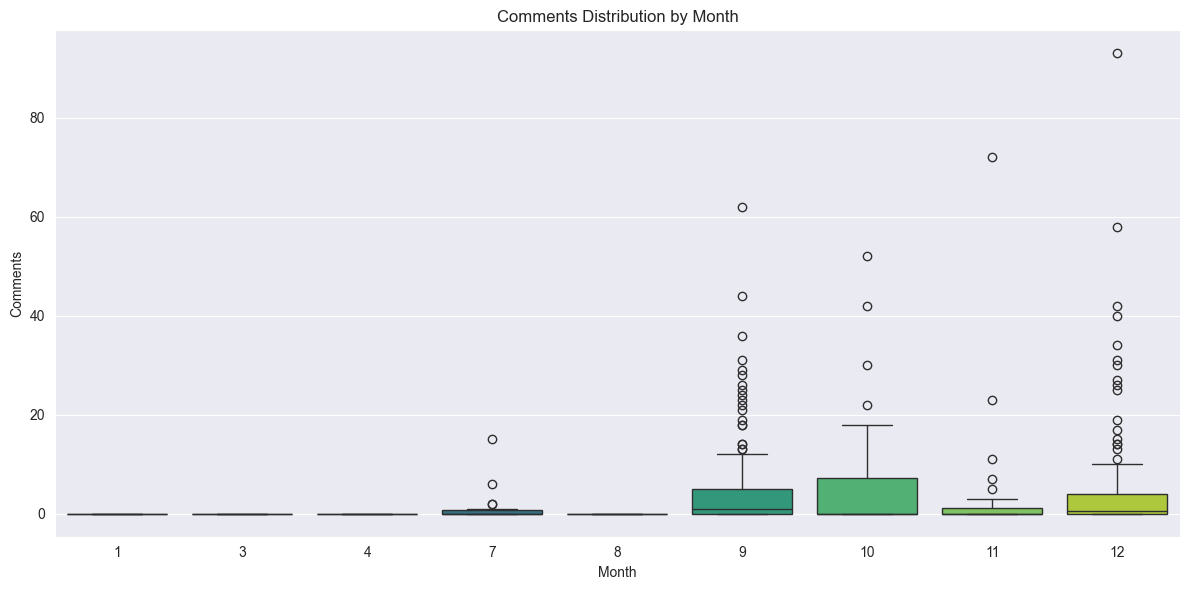

In [107]:
# Data Visualization
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Month', y='likesCount', palette='coolwarm')
plt.title("Likes Distribution by Month")
plt.xlabel("Month")
plt.ylabel("Likes")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Month', y='commentsCount', palette='viridis')
plt.title("Comments Distribution by Month")
plt.xlabel("Month")
plt.ylabel("Comments")
plt.tight_layout()
plt.show()

In [108]:
# Sentiment Level Generation
sid = SentimentIntensityAnalyzer()

# Function to get sentiment label from compound score
def get_vader_sentiment(text):
    score = sid.polarity_scores(str(text))['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply to dataset
df['sentiment'] = df['text'].apply(get_vader_sentiment)

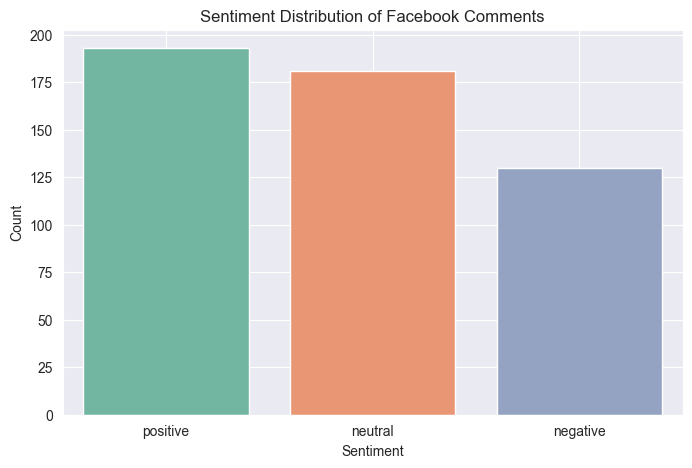

Sentiment Percentage Distribution:
sentiment
positive    38.29
neutral     35.91
negative    25.79
Name: proportion, dtype: float64


In [109]:
# Plot sentiment counts
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='sentiment', palette="Set2")
plt.title("Sentiment Distribution of Facebook Comments")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Percentage distribution
sentiment_pct = df['sentiment'].value_counts(normalize=True) * 100
print("Sentiment Percentage Distribution:")
print(sentiment_pct.round(2))

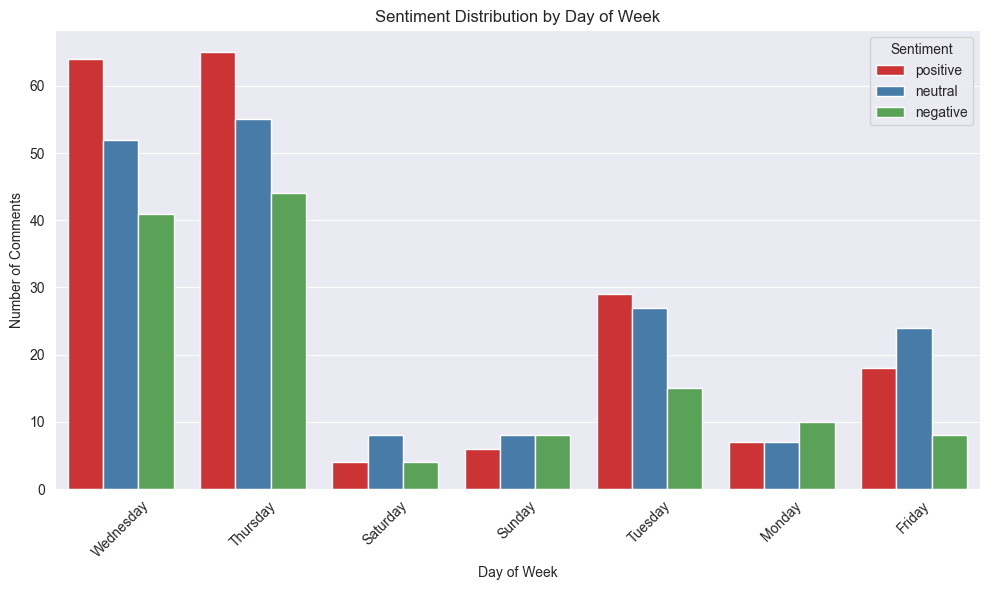

In [110]:
# Sentiment trends by day of the week
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='DayOfWeek', hue='sentiment', palette='Set1')
plt.title("Sentiment Distribution by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

In [111]:
# Time-based signals
df['hour'] = df['date'].dt.hour
df['dayofweek'] = df['date'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

In [112]:
# Compound Sentiment Score
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='hour', y='compoundScore', hue='sentiment', palette='Set2')
plt.title("Sentiment Score by Hour of the Day")
plt.xlabel("Hour of Day")
plt.ylabel("Compound Sentiment Score")
plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

ValueError: Could not interpret value `compoundScore` for `y`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>

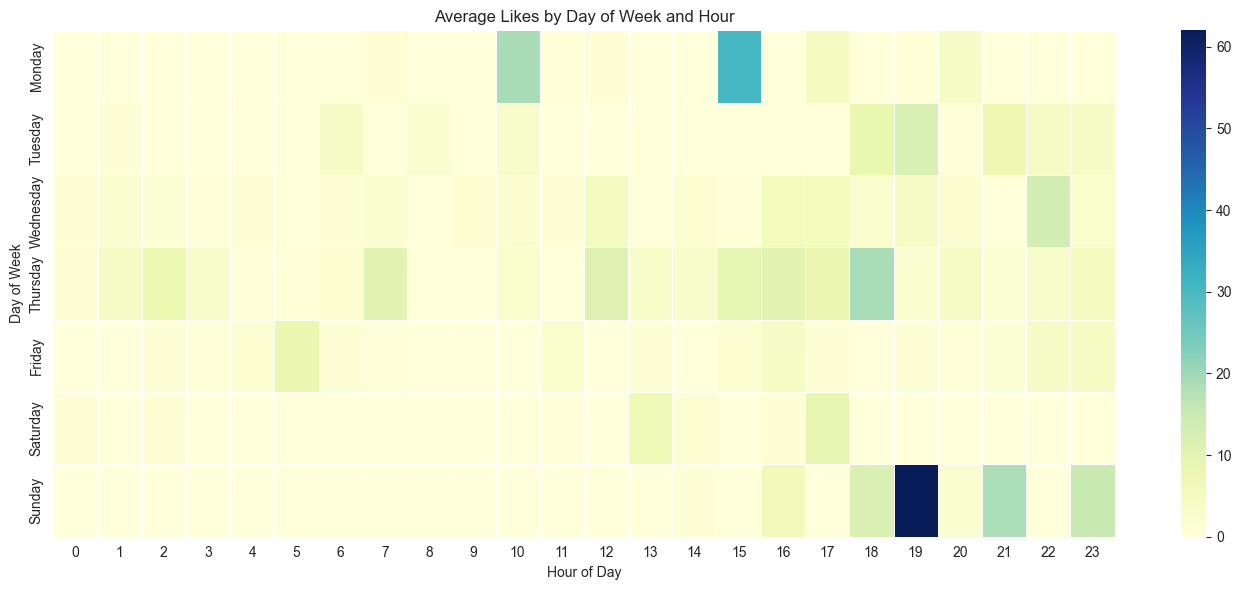

In [ ]:
# Pivot table of average likes by day and hour
engagement_pivot = df.pivot_table(index='DayOfWeek', columns='hour', values='likesCount', aggfunc='mean').fillna(0)

# Reorder days
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
engagement_pivot = engagement_pivot.reindex(ordered_days)

plt.figure(figsize=(14, 6))
sns.heatmap(engagement_pivot, cmap='YlGnBu', annot=False, linewidths=0.5)
plt.title("Average Likes by Day of Week and Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()

Average Engagement by Sentiment:


,likesCount,commentsCount
sentiment,,
negative,6.98,5.08
neutral,2.04,3.31
positive,6.10,4.41


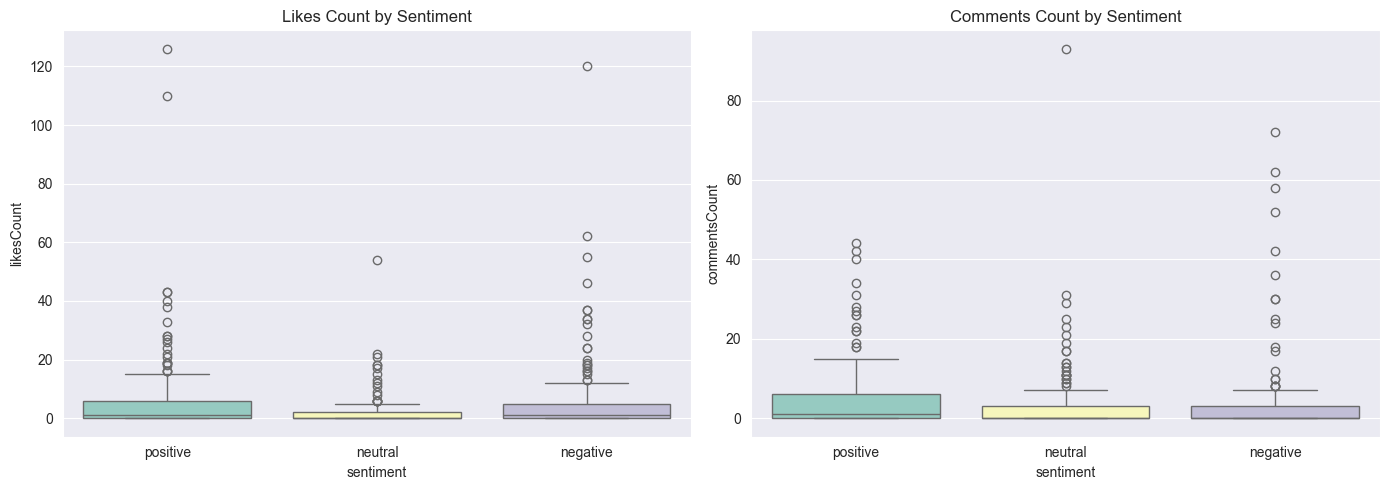

In [ ]:
# Engagement stats per sentiment
engagement_stats = df.groupby('sentiment')[['likesCount', 'commentsCount']].mean().round(2)
print("Average Engagement by Sentiment:")
display(engagement_stats)

# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(data=df, x='sentiment', y='likesCount', palette="Set3", ax=axes[0])
axes[0].set_title("Likes Count by Sentiment")

sns.boxplot(data=df, x='sentiment', y='commentsCount', palette="Set3", ax=axes[1])
axes[1].set_title("Comments Count by Sentiment")

plt.tight_layout()
plt.show()

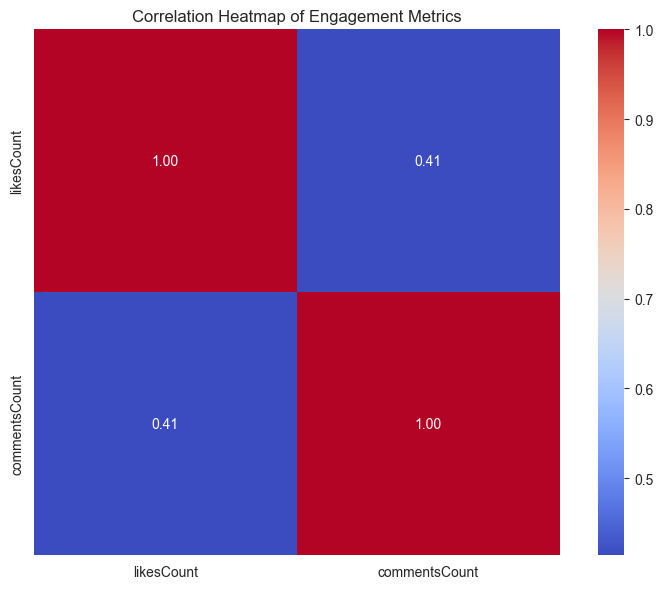

In [ ]:
# Correlation matrix for numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title("Correlation Heatmap of Engagement Metrics")
plt.tight_layout()
plt.show()

In [ ]:
# Initialize analyzer
sid = SentimentIntensityAnalyzer()

# Add compound score to each comment
df['compoundScore'] = df['text'].astype(str).apply(lambda x: sid.polarity_scores(x)['compound'])

In [ ]:
def get_vader_sentiment(text):
    score = sid.polarity_scores(str(text))['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['text'].apply(get_vader_sentiment)

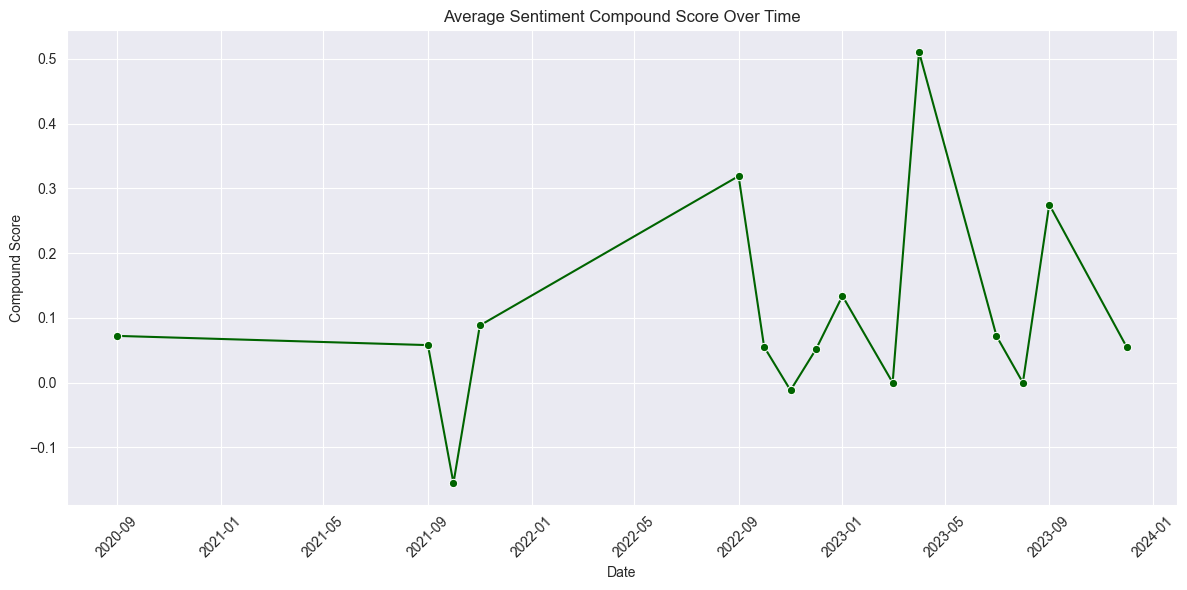

In [ ]:
# Time-based sentiment trend
df['YearMonth'] = df['date'].dt.to_period('M').dt.to_timestamp()
sentiment_over_time = df.groupby('YearMonth')['compoundScore'].mean().reset_index()

# Plot trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=sentiment_over_time, x='YearMonth', y='compoundScore', marker="o", color='darkgreen')
plt.title("Average Sentiment Compound Score Over Time")
plt.xlabel("Date")
plt.ylabel("Compound Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

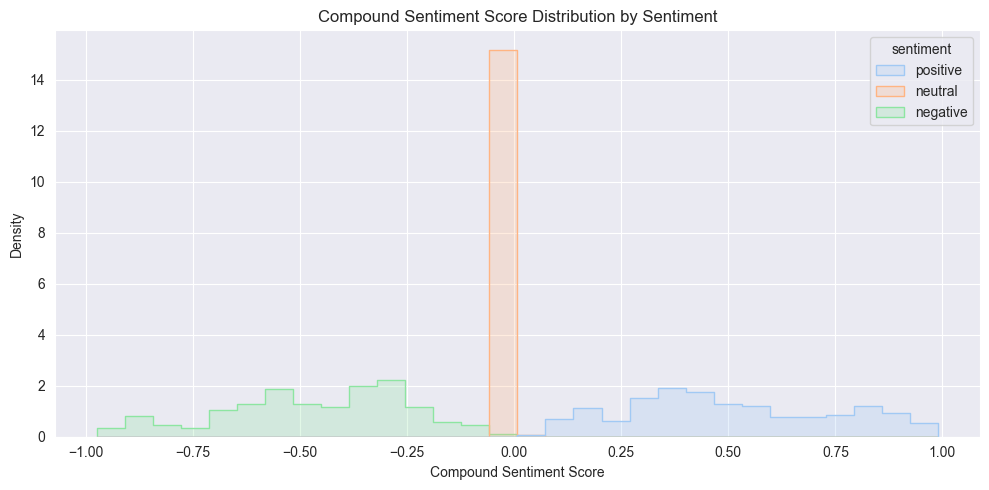

In [ ]:
# Compound Sentiment Score Distribution by Sentiment
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='compoundScore', hue='sentiment', element='step', stat='density', common_norm=False, palette='pastel', bins=30)
plt.title("Compound Sentiment Score Distribution by Sentiment")
plt.xlabel("Compound Sentiment Score")
plt.grid(True)
plt.tight_layout()
plt.show()

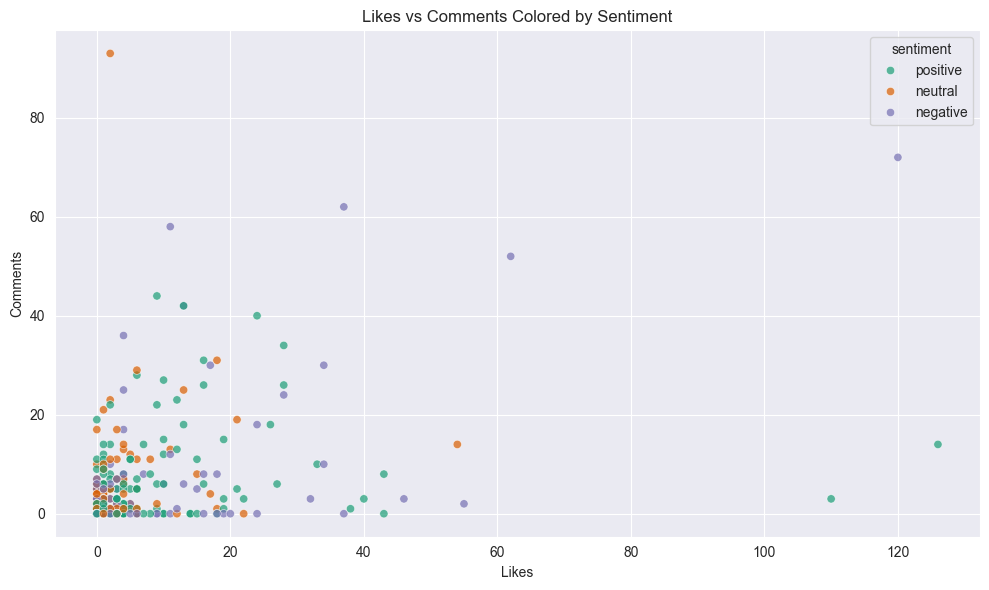

In [ ]:
# Likes vs Comments Colored by Sentiment
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='likesCount', y='commentsCount', hue='sentiment', alpha=0.7, palette='Dark2')
plt.title("Likes vs Comments Colored by Sentiment")
plt.xlabel("Likes")
plt.ylabel("Comments")
plt.grid(True)
plt.tight_layout()
plt.show()

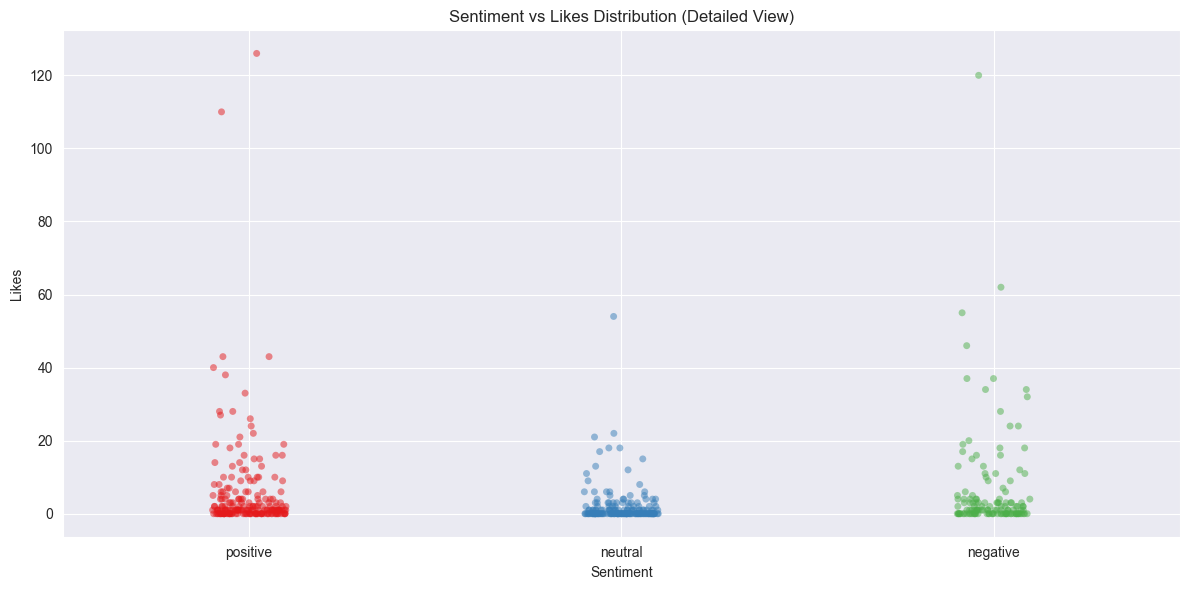

In [ ]:
# Sentiment vs Likes Distribution
plt.figure(figsize=(12, 6))
sns.stripplot(data=df, x='sentiment', y='likesCount', jitter=True, alpha=0.5, palette='Set1')
plt.title("Sentiment vs Likes Distribution (Detailed View)")
plt.xlabel("Sentiment")
plt.ylabel("Likes")
plt.grid(True)
plt.tight_layout()
plt.show()

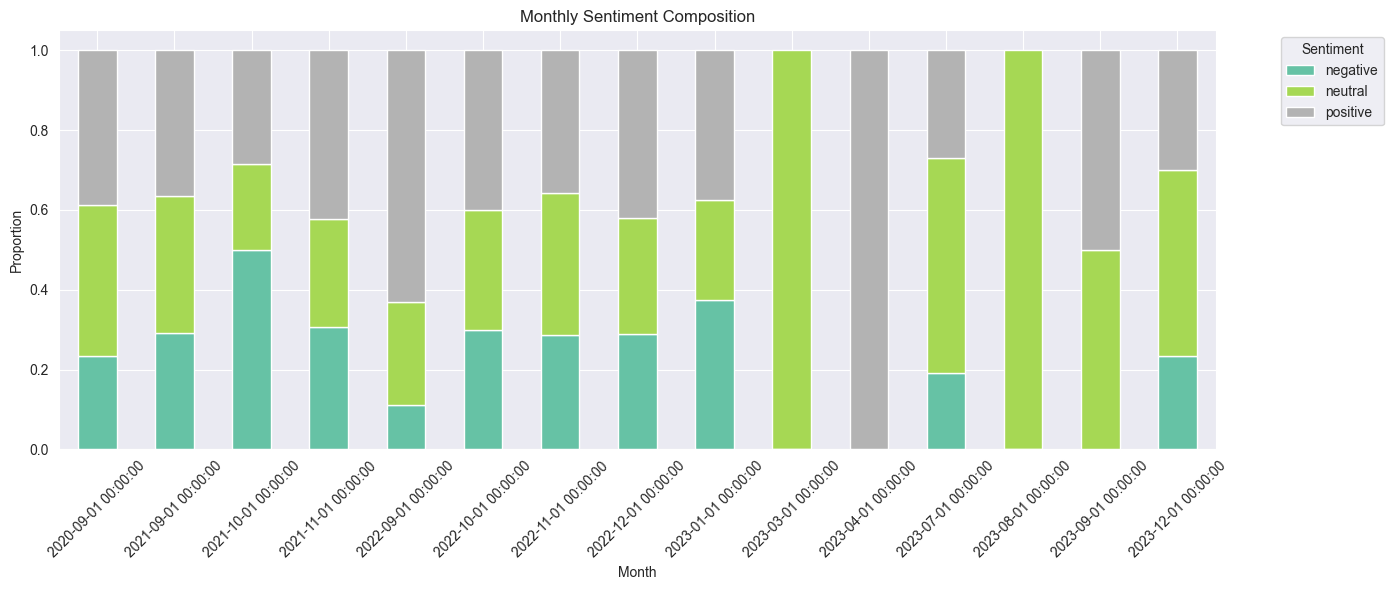

In [ ]:
# Monthly Sentiment Composition

sentiment_monthly = df.groupby(['YearMonth', 'sentiment']).size().unstack().fillna(0)
sentiment_monthly_pct = sentiment_monthly.div(sentiment_monthly.sum(axis=1), axis=0)

sentiment_monthly_pct.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='Set2')
plt.title("Monthly Sentiment Composition")
plt.xlabel("Month")
plt.ylabel("Proportion")
plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Clean the original comment text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@[A-Za-z0-9_]+", "", text)
    text = re.sub(r"#(\w+)", r"\1", text)
    text = re.sub(r"[^a-z0-9\s.,!?]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Apply cleaning
df['cleanText'] = df['text'].apply(clean_text)

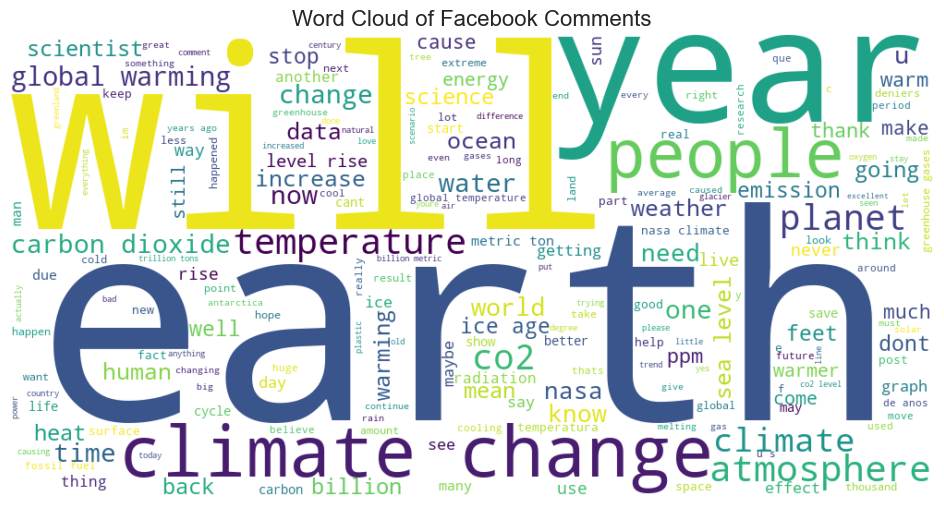

In [ ]:
# General WordCloud
all_words = " ".join(df['cleanText'])
wordcloud = WordCloud(width=1000, height=500, background_color='white', stopwords=STOPWORDS).generate(all_words)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Facebook Comments", fontsize=16)
plt.show()

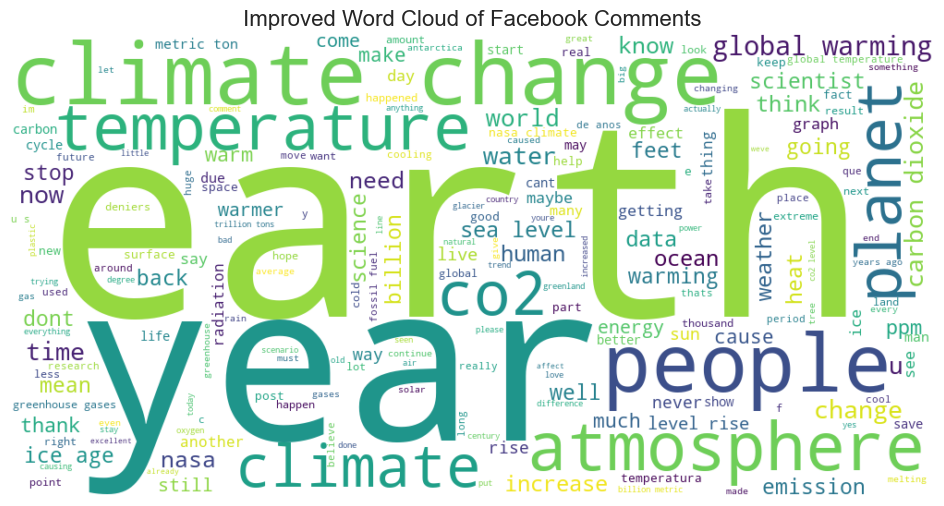

In [ ]:
# Extend stopword list
custom_stopwords = STOPWORDS.union({'will', 'would', 'could', 'also', 'one', 'get', 'like', 'use'})

# Generate better word cloud
wordcloud = WordCloud(width=1000, height=500, background_color='white', stopwords=custom_stopwords).generate(" ".join(df['cleanText']))

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Improved Word Cloud of Facebook Comments", fontsize=16)
plt.show()

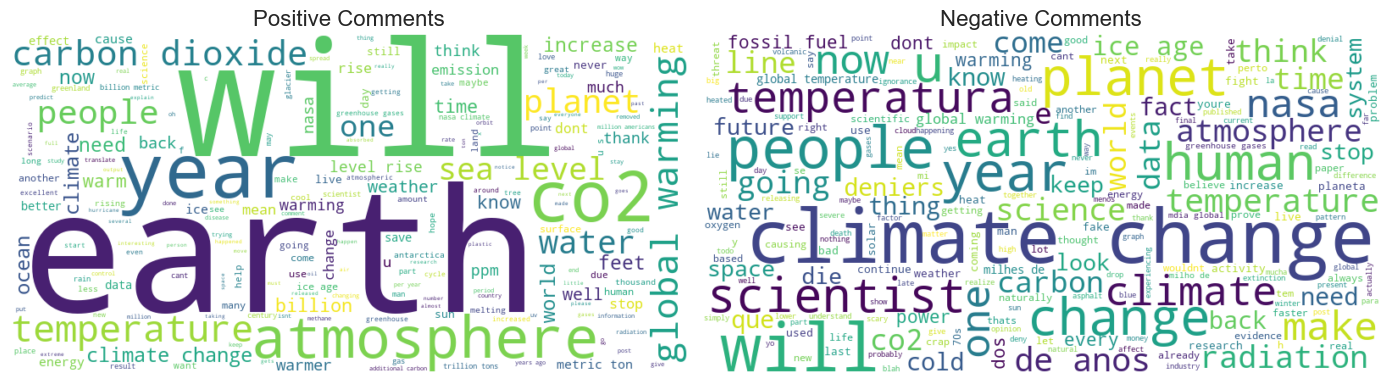

In [ ]:
# Split text by sentiment
positive_text = " ".join(df[df['sentiment'] == 'positive']['cleanText'])
negative_text = " ".join(df[df['sentiment'] == 'negative']['cleanText'])

positive_wc = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(positive_text)
negative_wc = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(negative_text)

# Plot side-by-side
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(positive_wc, interpolation='bilinear')
plt.axis("off")
plt.title("Positive Comments", fontsize=16)

plt.subplot(1, 2, 2)
plt.imshow(negative_wc, interpolation='bilinear')
plt.axis("off")
plt.title("Negative Comments", fontsize=16)

plt.tight_layout()
plt.show()

In [ ]:
# Extended stopword list

custom_stopwords = STOPWORDS.union({
    'will', 'would', 'could', 'should', 'get', 'got', 'one', 'use', 'also',
    'another', 'still', 'know', 'back', 'even', 'make', 'going', 'well',
    'much', 'many', 'may', 'want', 'like', 'way', 'say', 'see', 'thing',
    'cant', 'dont', 'never', 'need', 'every', 'really', 'yet', 'please',
    'let', 'u', 'us', 'think', 'someone', 'everything', 'nothing', 'time',
    'see', 'said', 'look', 'mean', 'man', 'people', 'thing', 'nasa',
    'keep', 'maybe', 'i', 'you', 'we', 'it', 'he', 'she', 'they', 'the', 
    'a', 'an', 'and', 'of', 'to', 'in', 'is', 'are', 'for', 'this', 'that'
})

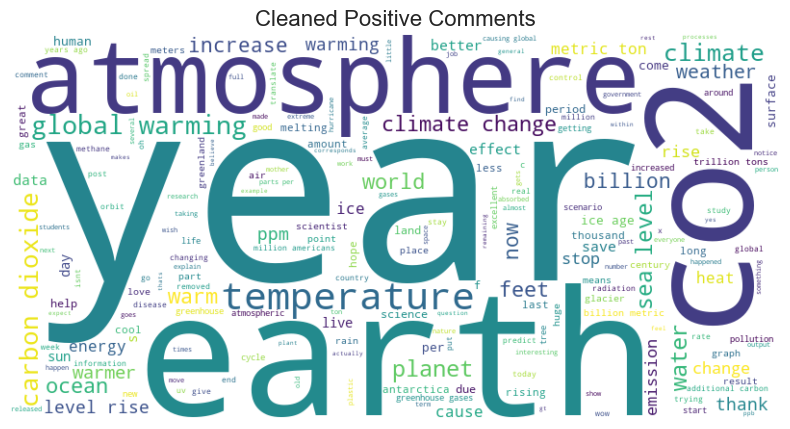

In [ ]:
positive_text = " ".join(df[df['sentiment'] == 'positive']['cleanText'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white',
                               stopwords=custom_stopwords).generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.title("Cleaned Positive Comments", fontsize=16)
plt.show()

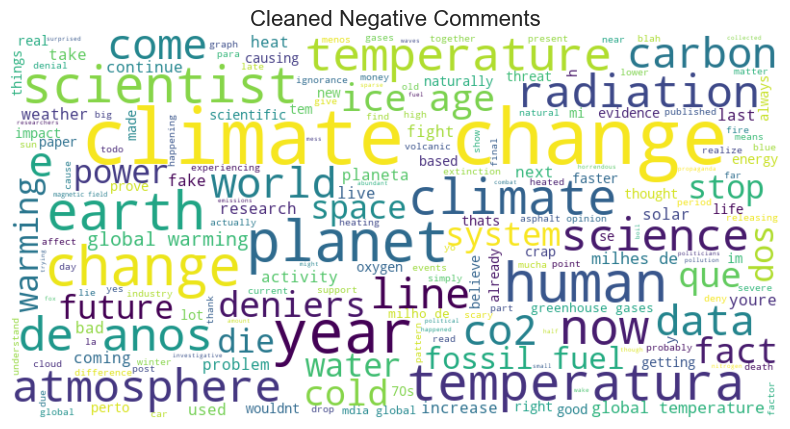

In [ ]:
negative_text = " ".join(df[df['sentiment'] == 'negative']['cleanText'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white',
                               stopwords=custom_stopwords).generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.title("Cleaned Negative Comments", fontsize=16)
plt.show()

In [ ]:
def plot_top_words(texts, title, n=15):
    # Ensure input is clean text only
    all_text = " ".join(texts.dropna().astype(str)).lower().split()
    
    # Remove stopwords and short words
    filtered = [word for word in all_text if word not in custom_stopwords and len(word) > 2]
    
    # Count and select top words
    top_words = Counter(filtered).most_common(n)
    
    # Avoid crashing if no words found
    if not top_words:
        print(f"No meaningful words found for: {title}")
        return
    
    # Plot
    words, counts = zip(*top_words)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts), y=list(words), palette='crest')
    plt.title(title)
    plt.xlabel("Frequency")
    plt.tight_layout()
    plt.show()

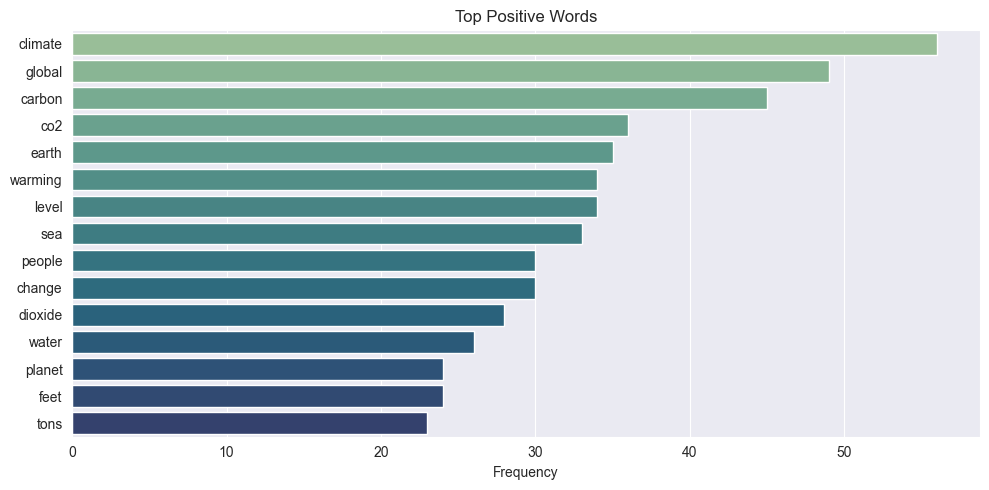

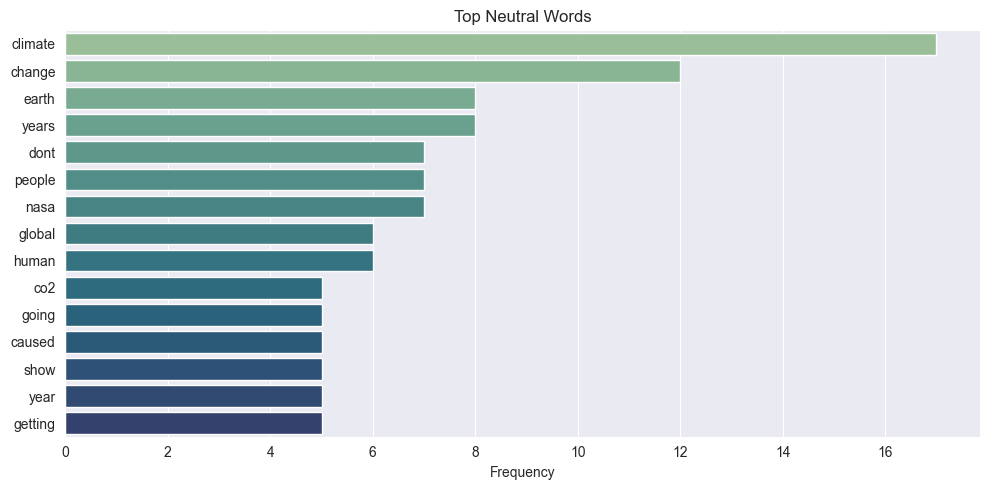

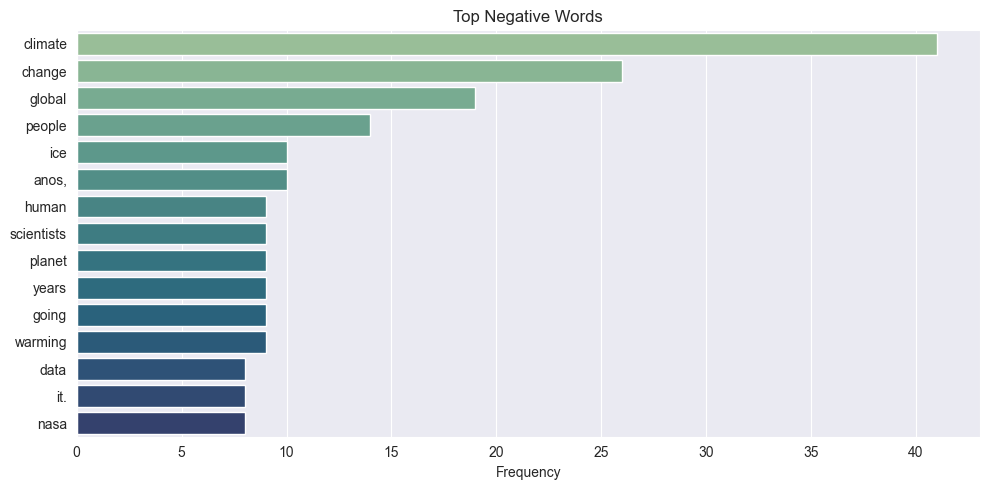

In [ ]:
# Positive Sentiment
plot_top_words(df[df['sentiment'] == 'positive']['cleanText'], "Top Positive Words")

# Neutral Sentiment
plot_top_words(df[df['sentiment'] == 'neutral']['cleanText'], "Top Neutral Words")

# Negative Sentiment
plot_top_words(df[df['sentiment'] == 'negative']['cleanText'], "Top Negative Words")

In [ ]:
# Lemmatize to improve NLP model understanding
nltk.download('wordnet', quiet=True)
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df['lemmatizedText'] = df['cleanText'].apply(lemmatize_text)

In [ ]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    ngram_range=(1, 2)  # Includes bigrams for more context
)

X_text = vectorizer.fit_transform(df['cleanText'])  # or 'lemmatizedText'

In [ ]:
# Encode sentiment
sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['sentiment_label'] = df['sentiment'].map(sentiment_map)

y_classification = df['sentiment_label']

In [ ]:
# Normalize regression targets if needed 
y_likes = df['likesCount']
y_comments = df['commentsCount']

In [ ]:
# Classification: Stratified split
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_text, y_classification, test_size=0.2, stratify=y_classification, random_state=42
)

# Regression: Random split
X_train_reg, X_test_reg, y_likes_train, y_likes_test = train_test_split(
    X_text, y_likes, test_size=0.2, random_state=42
)

_, _, y_comments_train, y_comments_test = train_test_split(
    X_text, y_comments, test_size=0.2, random_state=42
)

In [ ]:
# Scale features for regression if using neural nets
scaler = StandardScaler(with_mean=False)
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)

In [ ]:
# Text meta features
df['char_count'] = df['cleanText'].apply(len)
df['word_count'] = df['cleanText'].apply(lambda x: len(x.split()))
df['avg_word_length'] = df['cleanText'].apply(lambda x: np.mean([len(w) for w in x.split()]) if x else 0)
df['has_question'] = df['cleanText'].apply(lambda x: 1 if '?' in x else 0)
df['has_exclamation'] = df['cleanText'].apply(lambda x: 1 if '!' in x else 0)

In [ ]:

# Feature matrix for regression models: [text + numeric]
X_meta = df[['char_count', 'word_count', 'avg_word_length', 'has_question',
             'has_exclamation', 'hour', 'dayofweek', 'is_weekend']]

X_meta_np = X_meta.to_numpy()
X_hybrid = hstack([X_text, X_meta_np])

# Split for regression with hybrid features
X_train_hybrid, X_test_hybrid, _, _ = train_test_split(
    X_hybrid, df['likesCount'], test_size=0.2, random_state=42
)

In [ ]:
# Define models
models_cls = {
    'Logistic Regression': LogisticRegression(max_iter=500),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

# Train and evaluate
results_cls = {}
for name, model in models_cls.items():
    model.fit(X_train_cls, y_train_cls)
    preds = model.predict(X_test_cls)
    acc = accuracy_score(y_test_cls, preds)
    results_cls[name] = acc
    
    print(f"\n{name} Accuracy: {acc:.4f}")
    print("Classification Report:\n", classification_report(y_test_cls, preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test_cls, preds))


Logistic Regression Accuracy: 0.5743
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.35      0.45        26
           1       0.57      0.69      0.62        36
           2       0.56      0.62      0.59        39

    accuracy                           0.57       101
   macro avg       0.59      0.55      0.55       101
weighted avg       0.58      0.57      0.56       101

Confusion Matrix:
 [[ 9  9  8]
 [ 0 25 11]
 [ 5 10 24]]

Decision Tree Accuracy: 0.5743
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.23      0.29        26
           1       0.55      0.75      0.64        36
           2       0.69      0.64      0.67        39

    accuracy                           0.57       101
   macro avg       0.54      0.54      0.53       101
weighted avg       0.56      0.57      0.56       101

Confusion Matrix:
 [[ 6 12  8]
 [ 6 27  3]
 [ 4 10 25]]

Random 

In [ ]:
# Best performing classifier
best_model_name = max(results_cls, key=results_cls.get)
print(f"\nBest Sentiment Model: {best_model_name} with accuracy {results_cls[best_model_name]:.4f}")


Best Sentiment Model: Gradient Boosting with accuracy 0.6337


In [ ]:
# Models to try
models_reg = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

# Evaluate on Likes
print("\n--- Predicting Likes ---")
for name, model in models_reg.items():
    model.fit(X_train_hybrid, y_likes_train)
    preds = model.predict(X_test_hybrid)
    
    print(f"\n{name}")
    print(f"MAE: {mean_absolute_error(y_likes_test, preds):.2f}")
    print(f"MSE: {mean_squared_error(y_likes_test, preds):.2f}")
    print(f"R²: {r2_score(y_likes_test, preds):.2f}")


--- Predicting Likes ---

Random Forest
MAE: 6.35
MSE: 248.41
R²: -0.03

Gradient Boosting
MAE: 6.41
MSE: 248.93
R²: -0.04

MLP Regressor
MAE: 8.02
MSE: 273.51
R²: -0.14


In [ ]:
# Evaluate on Comments
print("\n--- Predicting Comments ---")
for name, model in models_reg.items():
    model.fit(X_train_hybrid, y_comments_train)
    preds = model.predict(X_test_hybrid)

    print(f"\n{name}")
    print(f"MAE: {mean_absolute_error(y_comments_test, preds):.2f}")
    print(f"MSE: {mean_squared_error(y_comments_test, preds):.2f}")
    print(f"R²: {r2_score(y_comments_test, preds):.2f}")


--- Predicting Comments ---

Random Forest
MAE: 6.11
MSE: 174.81
R²: -0.23

Gradient Boosting
MAE: 6.78
MSE: 221.11
R²: -0.55

MLP Regressor
MAE: 6.66
MSE: 131.55
R²: 0.08


<Figure size 600x500 with 0 Axes>

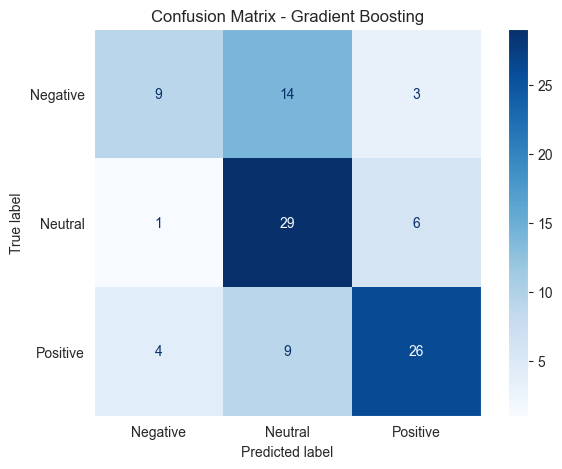

In [ ]:
# Use the best classifier
best_model = models_cls[best_model_name]
y_pred_cls = best_model.predict(X_test_cls)

# Plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_estimator(best_model, X_test_cls, y_test_cls,
                                      display_labels=['Negative', 'Neutral', 'Positive'],
                                      cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix - {best_model_name}")
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
# Display precision/recall/F1 visually
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

report = classification_report(y_test_cls, y_pred_cls, output_dict=True)
df_report = pd.DataFrame(report).transpose()

df_report.iloc[:-1, :3].plot(kind='bar', figsize=(10, 5))
plt.title("Classification Metrics by Class")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1.1)
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'y_pred_cls' is not defined

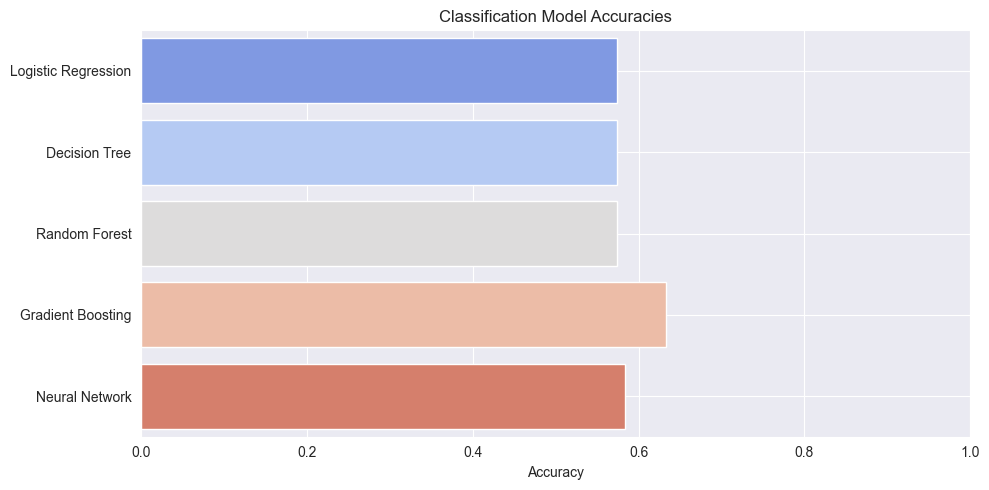

In [ ]:
# Visualize accuracy scores of all models
model_names = list(results_cls.keys())
accuracies = list(results_cls.values())

plt.figure(figsize=(10, 5))
sns.barplot(x=accuracies, y=model_names, palette="coolwarm")
plt.xlabel("Accuracy")
plt.title("Classification Model Accuracies")
plt.xlim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 500x400 with 0 Axes>

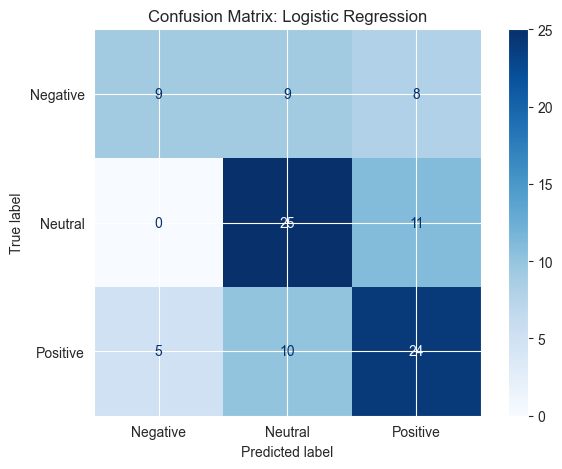

<Figure size 500x400 with 0 Axes>

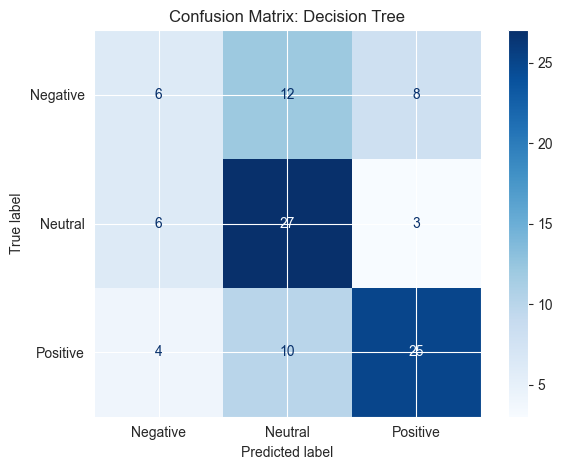

<Figure size 500x400 with 0 Axes>

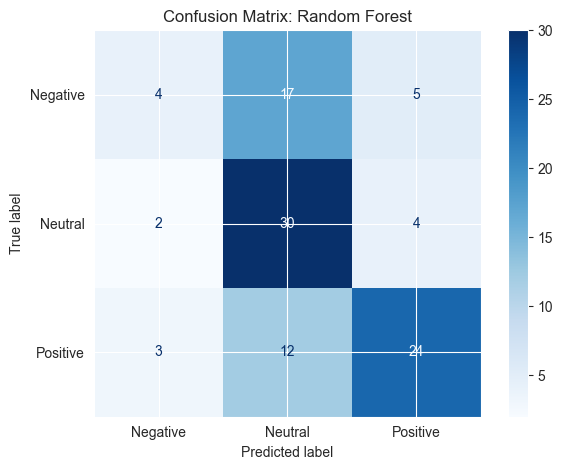

<Figure size 500x400 with 0 Axes>

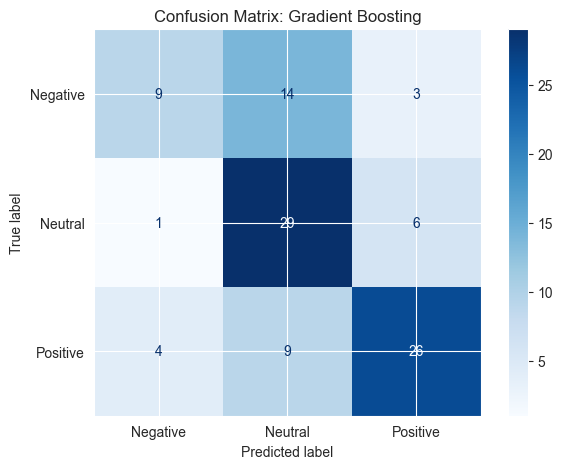

<Figure size 500x400 with 0 Axes>

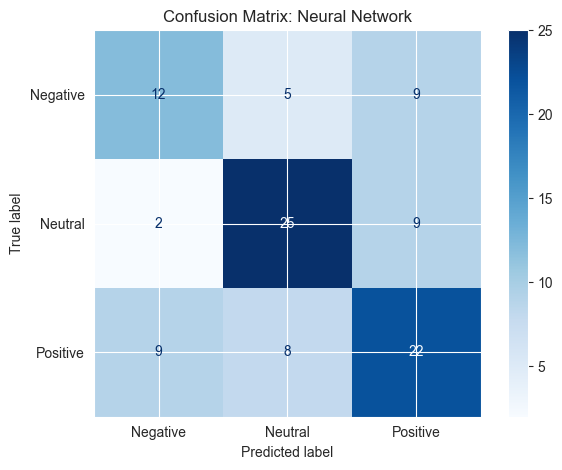

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrices for all models
for name, model in models_cls.items():
    plt.figure(figsize=(5, 4))
    ConfusionMatrixDisplay.from_estimator(
        model, X_test_cls, y_test_cls,
        display_labels=['Negative', 'Neutral', 'Positive'],
        cmap='Blues',
        values_format='d'
    )
    plt.title(f"Confusion Matrix: {name}")
    plt.tight_layout()
    plt.show()

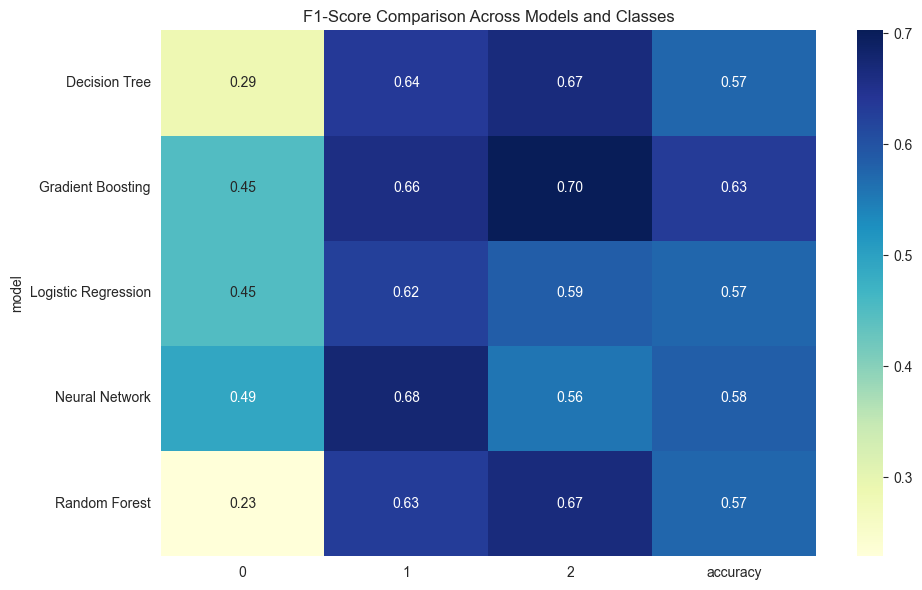

In [ ]:
# Collect reports for all models
metric_df = pd.DataFrame()

for name, model in models_cls.items():
    y_pred = model.predict(X_test_cls)
    report = classification_report(y_test_cls, y_pred, output_dict=True)
    temp_df = pd.DataFrame(report).T
    temp_df['model'] = name
    metric_df = pd.concat([metric_df, temp_df])

# Remove average rows
metric_df = metric_df[~metric_df.index.str.contains("avg|support")]

# Pivot for heatmap
pivot_df = metric_df.pivot_table(index='model', columns=metric_df.index, values='f1-score')

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title("F1-Score Comparison Across Models and Classes")
plt.tight_layout()
plt.show()

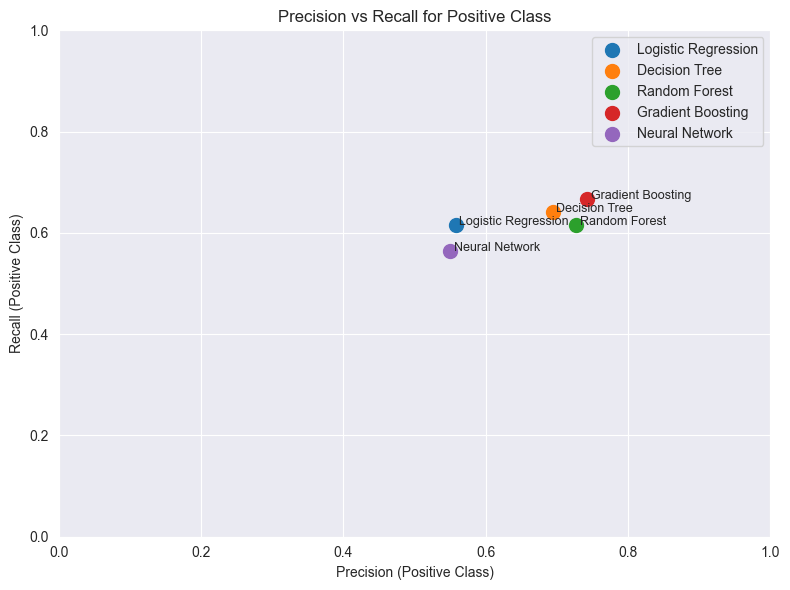

In [ ]:
# Scatter plot of precision vs recall for each model on 'positive' class
precision_recall = []

for name, model in models_cls.items():
    report = classification_report(y_test_cls, model.predict(X_test_cls), output_dict=True)
    if '2' in report:  # class '2' = positive
        precision = report['2']['precision']
        recall = report['2']['recall']
        precision_recall.append((name, precision, recall))

# Plot
plt.figure(figsize=(8, 6))
for name, p, r in precision_recall:
    plt.scatter(p, r, label=name, s=100)
    plt.text(p + 0.005, r, name, fontsize=9)

plt.xlabel("Precision (Positive Class)")
plt.ylabel("Recall (Positive Class)")
plt.title("Precision vs Recall for Positive Class")
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.legend()
plt.show()

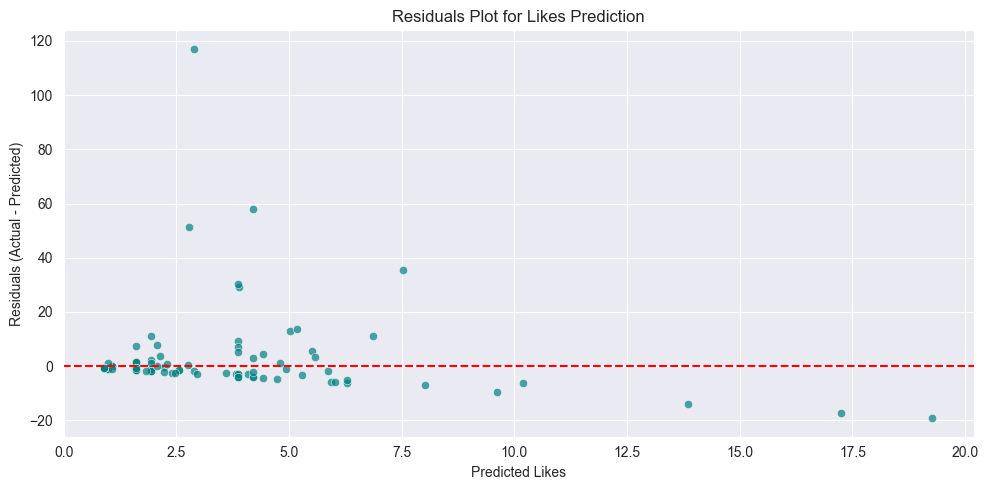

In [ ]:
# Use best regressor (e.g., Gradient Boosting for likes)
best_reg_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
best_reg_model.fit(X_train_hybrid, y_likes_train)
likes_preds = best_reg_model.predict(X_test_hybrid)

# Residual plot
residuals = y_likes_test - likes_preds

plt.figure(figsize=(10, 5))
sns.scatterplot(x=likes_preds, y=residuals, color='teal', alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals Plot for Likes Prediction")
plt.xlabel("Predicted Likes")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()

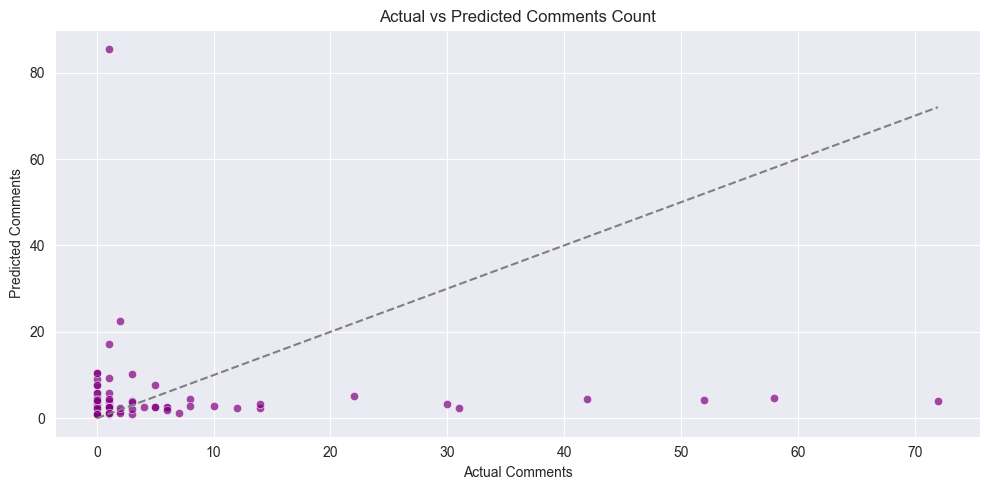

In [ ]:
# Comments: actual vs predicted
best_reg_model.fit(X_train_hybrid, y_comments_train)
comments_preds = best_reg_model.predict(X_test_hybrid)

plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_comments_test, y=comments_preds, color='purple', alpha=0.7)
plt.plot([0, max(y_comments_test)], [0, max(y_comments_test)], linestyle='--', color='gray')
plt.title("Actual vs Predicted Comments Count")
plt.xlabel("Actual Comments")
plt.ylabel("Predicted Comments")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Example unseen comments (simulate user input or future posts)
future_comments = [
    "The climate crisis is worsening every year. We need urgent action!",
    "Great job NASA for sharing this amazing climate update!",
    "I don't believe climate change is real. This is just natural weather."
]

# Clean the new data
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@[A-Za-z0-9_]+", "", text)
    text = re.sub(r"#(\w+)", r"\1", text)
    text = re.sub(r"[^a-z0-9\s.,!?]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

future_clean = [clean_text(comment) for comment in future_comments]

In [ ]:
# Vectorize new data
X_future = vectorizer.transform(future_clean)

# Predict sentiment
predicted_sentiments = best_model.predict(X_future)

# Decode
sentiment_reverse_map = {0: "negative", 1: "neutral", 2: "positive"}
decoded_sentiments = [sentiment_reverse_map[s] for s in predicted_sentiments]

# Display results
for comment, sentiment in zip(future_comments, decoded_sentiments):
    print(f"\nComment: {comment}\nPredicted Sentiment: {sentiment}")


Comment: The climate crisis is worsening every year. We need urgent action!
Predicted Sentiment: neutral

Comment: Great job NASA for sharing this amazing climate update!
Predicted Sentiment: positive

Comment: I don't believe climate change is real. This is just natural weather.
Predicted Sentiment: negative


In [ ]:
# Create basic meta features for future comments
def generate_meta_features(texts):
    return pd.DataFrame({
        'char_count': [len(t) for t in texts],
        'word_count': [len(t.split()) for t in texts],
        'avg_word_length': [np.mean([len(w) for w in t.split()]) if t else 0 for t in texts],
        'has_question': [1 if '?' in t else 0 for t in texts],
        'has_exclamation': [1 if '!' in t else 0 for t in texts],
        'hour': [12]*len(texts),  # Assume posting at noon
        'dayofweek': [2]*len(texts),  # Assume Wednesday
        'is_weekend': [0]*len(texts)  # Assume weekday
    })

X_meta_future = generate_meta_features(future_clean).to_numpy()
X_hybrid_future = hstack([X_future, X_meta_future])

# Predict engagement
likes_predictions = best_reg_model.predict(X_hybrid_future)

# Display
for comment, likes in zip(future_comments, likes_predictions):
    print(f"\nComment: {comment}\nPredicted Likes: {int(likes)}")


Comment: The climate crisis is worsening every year. We need urgent action!
Predicted Likes: 2

Comment: Great job NASA for sharing this amazing climate update!
Predicted Likes: 22

Comment: I don't believe climate change is real. This is just natural weather.
Predicted Likes: 10
